# 17. 프로젝트 - Movielens 영화 SBR

## 노드 정리
### Session-Based Recommendation
세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천이다. Session이란 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터이고, 서버 쪽에 저장된다. 유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받는다. 이 프로젝트에서는 세션을 브라우저가 종료되기 전까지 유저의 행동을 담은 시퀀스 데이터와 같은 의미로 사용한다. 그러나 이 프로젝트에서 사용된 데이터에는 sessionID아니라 UserID 항목이 들어가 있다. 따라서 UserID가 SessionID 역할을 한다고 생각하고 프로젝트를 진행한다.

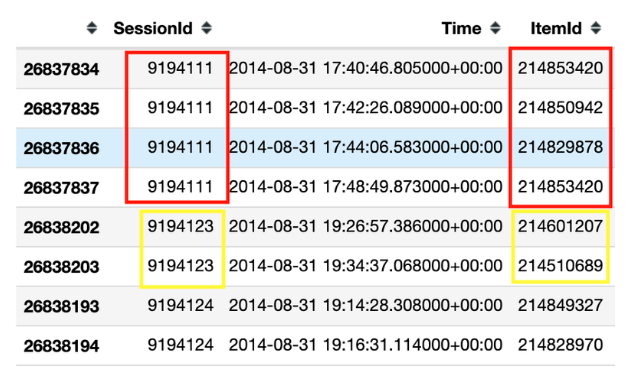

### GRU4REC
이 프로젝트에서 사용하는 모델은 2016년 ICLR에 공개된 [SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS](https://arxiv.org/pdf/1511.06939v4.pdf)이다.

모델 구조는 아래와 같다. 

![](https://images.velog.io/images/guide333/post/ac57d9bc-0a76-409c-8663-35e30441e648/Screenshot%20from%202021-03-11%2011-26-31.png)

여러 RNN 계열의 모델 중 GRU의 성능이 제일 좋았고, Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 저자는 말한다. 여기에서도 Embedding Layer를 사용하지 않고 One-hot Encoding만 사용한다.

#### Session-Parallel Mini-Batches
Session의 길이는 매우 짧은 것들이 대부분이나 매우 긴 것도 있다. 이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 한다.

그래서 논문의 저자는 대신 Session-Parallel Mini-Batches 를 제안한다. 아래 그림에서 session2가 끝나면 session4가 시작하는 방식이다. 이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루진다. 또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 준다. 

![](https://images.velog.io/images/guide333/post/f1d3b1e7-630a-4a9a-ab1a-a98800d4030e/Screenshot%20from%202021-03-11%2011-26-44.png)

Ranking Loss Session-Based Recommendation Task를 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task 로도 생각할 수 있다. 추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했다. 

![](https://images.velog.io/images/guide333/post/68051913-c762-4c3b-a4f1-bec31ba11562/Screenshot%20from%202021-03-14%2016-20-42.png)

그러나 이번 프로젝트에서는 Classification Task로 보고 Cross-Entropy Loss를 사용한다.

#### Ranking Loss
Ranking Loss가 무엇인지 궁금해서 간단한 개념만 살펴보았다.
> Ranking Loss
metric learning이라고 불리는 Ranking Losses의 목표는 inputs 사이의 상대적인 거리를 예측하는 것이다. Ranking Loss Function을 사용 방법은 다음과 같다. 1) 2개 혹은 3개의 input data points로부터 feature를 추출하고 각각의 그들로부터 embedded representation을 얻는다. 2) representation들 사이의 유사성(ex. euclidian distance)을 측정하는 metric function을 정의한다. 3) input들이 비슷하면 비슷한 representation을 생성하고, input들이 서로 다르면 거리가 먼 representation을 생성하도록 feature extractors를 훈련시킨다. 
> Ranking Losses Formulation은 대체로 두가지 버전(pairs of training data points 버전, triplets 버전)을 많이 사용한다.

<img src="https://images.velog.io/images/guide333/post/615e2f59-e9eb-452e-ac1c-e25122c87337/Screenshot%20from%202021-03-14%2017-26-04.png" width="500px" height="500px">

<img src="https://images.velog.io/images/guide333/post/405e4e5c-e4ce-40d2-8cd5-510525726d15/Screenshot%20from%202021-03-14%2017-26-17.png" width="500px" height="500px">

자세한 설명은 [여기](https://gombru.github.io/2019/04/03/ranking_loss/)참조. (코드는 [여기](https://github.com/tensorflow/ranking/blob/master/tensorflow_ranking/python/losses.py) 참조) 

## 순서
1. 데이터의 전처리 
2. 미니 배치의 구성 
3. 모델 구성
4. 모델 학습
5. 모델 테스트 

## 데이터 다운로드 및 준비

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 본다.
```python
1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 __UserID__ 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.
- __Rating 정보__ 가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.
- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

In [1]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


영화의 Rating이 3점 미만인 데이터를 살펴보았다. 영화의 평점이 3점 미만이라는 것은 User가 좋아하지 않는 영화라는 뜻으므로 3점 미만의 영화는 삭제하였다.

In [4]:
data[data['Rating'] < 3]

,UserId,ItemId,Rating,Time
67,2,1213,2,2000-12-31 21:34:18
151,2,1090,2,2000-12-31 21:36:20
174,2,1968,2,2000-12-31 21:41:21
83,2,902,2,2000-12-31 21:41:45
114,2,3699,2,2000-12-31 21:46:13
...,...,...,...,...
999892,6040,2402,1,2000-04-26 02:35:57
999902,6040,2421,1,2000-04-26 02:36:28
999963,6040,2147,2,2000-04-26 02:36:28
1000164,6040,154,2,2000-05-07 16:41:18


In [5]:
data = data[data['Rating'] > 2]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- pandas.to_datetime(arg, errors='raise', dayfirst=False, yearfirst=False, utc=None, format=None, exact=True, unit=None, infer_datetime_format=False, origin='unix', cache=True)    
: Convert argument to datetime.

- unit: str, default ‘ns’            
: The unit of the arg (D,s,ms,us,ns) denote the unit, which is an integer or float number. This will be based off the origin. Example, with unit=’ms’ and origin=’unix’ (the default), this would calculate the number of milliseconds to the unix epoch start.

## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

추천시스템을 구출할 때 가장 먼저 확인할 것은 유저수와 아이템의 갯수이다.

In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

유저수는 6040, 평점 3점 이상의 영화의 갯수는 3628개이다. 

### Session Length
한 유저가 몇 개의 영화를 보았는지 알아본다.

In [7]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [8]:
user_length.median(), user_length.mean()

(81.0, 138.51266766020865)

In [9]:
user_length.min(), user_length.max()

(1, 1968)

In [10]:
user_length.quantile(0.999)

1118.8860000000013

user_length는 한 유저가 클릭한 영화의 갯수를 말한다. 한 유저는 주어진 기간동안 평균 138번의 영화를 보았고, 99.9% 안에 들어있는 유저는 약 1118개 이하의 영화를 보았다. 가장 많은 영화를 본 유저의 정보를 확인해 본다.

In [12]:
long_user = user_length[user_length==1968].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697055,4169,3207,3,2002-06-15 20:23:26
695958,4169,3413,3,2002-06-15 20:33:11
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00


In [13]:
data[data['UserId']==long_user][:20]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
697903,4169,3761,3,2000-08-03 20:11:21
697954,4169,3788,3,2000-08-03 20:11:21
695653,4169,3794,4,2000-08-03 20:11:59
696188,4169,3811,5,2000-08-03 20:11:59


4169번의 유저는 같은 시간에 서로 다른 영화를 클릭하고 rating까지 하였다. 초단위까지 같다는 것은 비정상적이라고 생각된다. 그러나 4169번의 유저의 클릭 영화수(2314번)는 데이터에서 큰 비중을 차지하므로 우선은 없애지 않고 진행해본다. 

세션 길이에 대해 직관적으로 보기 위해 시각화를 한다. 세션 길이 기준 하위 99.9%까지의 분포 누적합을 시각화한다.

In [14]:
# session 별 누적합 시각화
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum() # 누적합
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

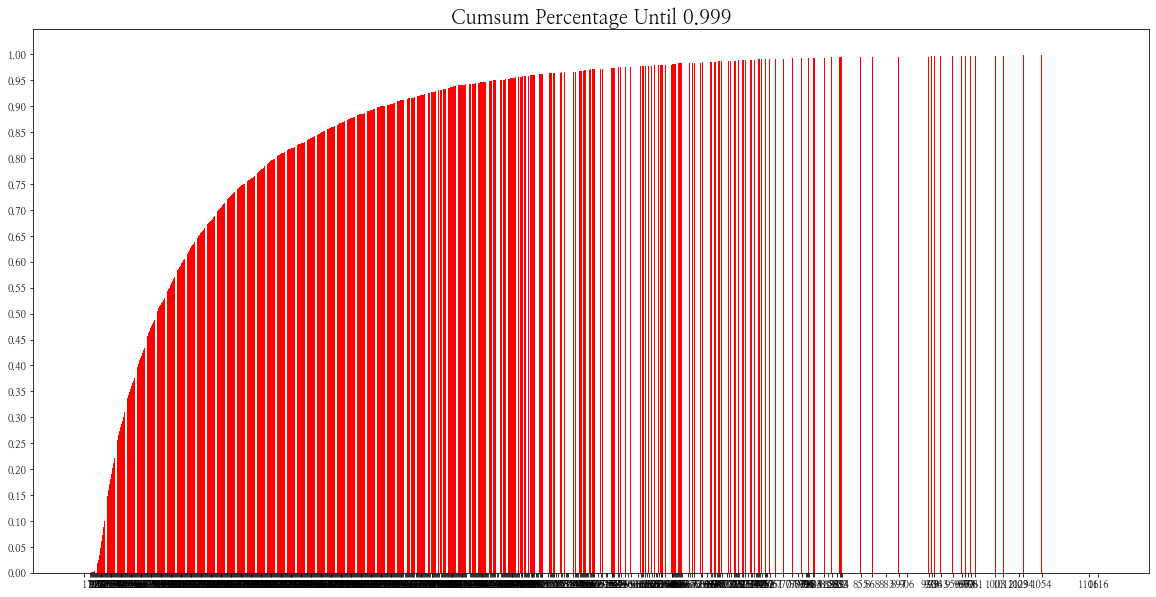

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()


- numpy.cumsum(a, axis=None, dtype=None, out=None)[source]     
: Return the cumulative sum of the elements along a given axis.
누적 분포합! 

### Session Time
데이터의 시간 관련 정보를 확인한다. 

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [17]:
len(user_length)

6039

총 3년치의 데이터라는 것을 알 수 있다. 그러나 데이터의 수가 많지 않기 때문에 그대로 사용할 것이다.

### Data Cleasing

In [19]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2000
2        551
3        339
4        102
5        214
        ... 
3948     752
3949     280
3950      47
3951      36
3952     353
Length: 3628, dtype: int64

In [20]:
item_length.min(), item_length.max()

(1, 3211)

In [21]:
item_length.median(), item_length.mean()

(87.0, 230.56174200661522)

영화를 살펴보았을 때, 1번 시청된 영화가 있음을 알 수 있다. 평균, 중앙값, 그리고 가장 많이 시청된 영화와 비교했을 때 너무 작은 수이므로 1번 이하로 시청된 영화는 제거한다. 

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest=1, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Train / Valid / Test split
모델 평가를 위해 Valid set과 Test set을 만든다. 추천 시스템은 지금 잘 예측하는 게 중요하다. 사용자들의 취향이 달라지기 때문에 오래 전 만들었던 성능이 좋은 모델을 지금 쓰면 맞지 않을 수 있다. 따라서 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 한다. 

그러므로 이번 자료에서는 총 3년의 기간 중, 6개월 전부터 3개월 전까지를 valid set으로, 가장 마지막 3달 동안을 Test로 나눌 것이다. (0.8:0.1:0.1)

In [24]:
import datetime as dt

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [25]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 721726
	 Users: 5706
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 00:14:13

* valid Set Stats Info
	 Events: 33542
	 Users: 103
	 Items: 2849
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 80522
	 Users: 230
	 Items: 3147
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

준비된 데이터를 저장한다.

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

- DataFrame.to_pickle(path, compression='infer', protocol=5, storage_options=None)

Pickle (serialize) object to file. 판다스 데이터프레임 저장.
불러올 때는 read_picke 사용

### Data Pipeline 
#### Session Dataset
세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

train데이터로 SessionDataset 객체를 만든다. click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있고, session_idx 변수는 각 세션을 인덱싱한 np.array이다.

In [30]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [31]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [32]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 721331, 721450, 721726], dtype=int32)

In [33]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5703, 5704, 5705])

#### Session Data Loader
Session Data Loader는 SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다. iter 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 산출하고, mask는 후에 RNN Cell State를 초기화 하는데 사용할 것이다. 

In [34]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [35]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [36]:
iter_ex = iter(tr_data_loader)

아래의 셀을 반복하면 next가 다음 데이터를 계속 만든다.

In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

### Evaluation Metric
recall의 개념을 확장한 recall@k 지표와 정답 아이템이 나온 순법의 역수값인 MRR을 사용한다. 

In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyperparameter를 class 형식으로 관리한다.

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.


In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [44]:
train_model(model, args)

Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.88]

	 - Recall@20 epoch 1: 0.241990
	 - MRR@20    epoch 1: 0.060929



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.38]

	 - Recall@20 epoch 2: 0.289147
	 - MRR@20    epoch 2: 0.079185



Evaluation:  53%|█████▎    | 277/522 [01:02<00:55,  4.45it/s]

	 - Recall@20 epoch 3: 0.302685
	 - MRR@20    epoch 3: 0.085347



- 모델 학습에서 자꾸만 에러 메시지가 나왔다. 

"IndexError: index 152 is out of bounds for axis 0 with size 152"

코드를 비교도 해보고 새로 다시 써보기도 했지만 계속해서 에러 메시지가 나왔다. 구글링을 해도 답이 안 나와서 에러 메시지를 가만히 보다 보니 배치 사이즈 사이즈가 너무 커서 그런 것은 아닐까 하는 생각이 들었다. 그래서 배치 사이즈를 2048->256->128로 줄여도 같은 에러 메시지가 나왔다. 결국 배치 사이즈를 더 작은 56으로 줄이고 나서야 학습이 가능해졌다. 현재 주어진 데이터의 수가 적고 validation으로 설정한 기간이 짧기 때문에 이런 문제가 생겼던 것 같다. 

## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증해 본다.

In [45]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  78%|███████▊  | 984/1254 [03:30<00:57,  4.68it/s]

	 - Recall@20: 0.248174
	 - MRR@20: 0.069336



## Step 6. 다양한 하이퍼파라미터 시도

#### 첫번째 시도
- batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20    

In [46]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model = create_model(args)

result = train_model(model, args)

Train:   0%|          | 0/11187 [00:00<?, ?it/s]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.92]

	 - Recall@20 epoch 1: 0.242554
	 - MRR@20    epoch 1: 0.062474



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.23]

	 - Recall@20 epoch 2: 0.284973
	 - MRR@20    epoch 2: 0.077821



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.54]

	 - Recall@20 epoch 3: 0.300542
	 - MRR@20    epoch 3: 0.084729



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.13]

	 - Recall@20 epoch 4: 0.306069
	 - MRR@20    epoch 4: 0.089251



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.47]

	 - Recall@20 epoch 5: 0.310018
	 - MRR@20    epoch 5: 0.091620



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.29]

	 - Recall@20 epoch 6: 0.312274
	 - MRR@20    epoch 6: 0.093097



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.49]

	 - Recall@20 epoch 7: 0.314700
	 - MRR@20    epoch 7: 0.093367



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.27]

	 - Recall@20 epoch 8: 0.312951
	 - MRR@20    epoch 8: 0.093717



Train:   0%|          | 0/11187 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.32]

	 - Recall@20 epoch 9: 0.313628
	 - MRR@20    epoch 9: 0.093971



Evaluation:  53%|█████▎    | 277/522 [00:56<00:50,  4.87it/s]

	 - Recall@20 epoch 10: 0.312951
	 - MRR@20    epoch 10: 0.094407



In [47]:
test_model(model, args, test)

Evaluation:  78%|███████▊  | 984/1254 [03:16<00:53,  5.00it/s]

	 - Recall@20: 0.260623
	 - MRR@20: 0.076348



에포크를 10번으로 늘리니 3번 학습한 것보다 성능이 아주 조금 높아졌다. 

### 정리
1. 처음에는 rating을 고려하지 않고 모델을 학습시켰다. 그 결과는 아래와 같다. 
- 기본 하이퍼파라미터: batch_size=56, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20

|Hyperparameter|Recall    |MRR      |
|:------------:|:--------:|:--------:|
|기본 | 0.257508|0.074025|
|batch_size=64,epochs=10|0.267331|0.079640|
|hsz=100 |0.266728|0.079891|
|dropout=0.5|0.265843|0.077415|
|lr=0.005|0.234709|0.065160|
|K=30 |0.267241 |0.079917|
|batch_size=32 |0.251848|0.074413|
|epoch=30 |0.0.253207 |0.076031|

하이퍼파라미터를 다양하게 바꿔보았으나 Recall과 MRR의 결과는 별 차이가 없었다. 

2. 나중에 rating을 고려해야 한다는 것을 깨닫고 3점 미만의 평점의 영화는 제거하고 모델을 학습시켰다. 그 결과는 아래와 같다. 
- 기본 하이퍼파라미터: batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20
|Hyperparameter|Recall    |MRR      |
|:------------:|:--------:|:--------:|
|기본 | 0.248174|0.069336|
|epochs=10|0.260623|0.076348|

평점 3점 미만의 영화를 제거하여도 Recall과 MRR의 결과의 차이는 거의 없었다. 

3. 마지막으로 비정상적인 클릭수와 평점 평가가 많았던 4139번의 User를 제거한 후 모델을 학습시켰다. 

- 기본 하이퍼파라미터: batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

|Hyperparameter|Recall    |MRR      |
|:------------:|:--------:|:--------:|
|기본 | 0.261639|0.077170|
 
하이퍼파라미터를 변경해보고, 데이터 전처리도 여러 가지로 해 보았으나 성능이 쉽게 오르지 않았다. 

(1번과 3번은 다른 노트북에서 실행하여서 결과만 적었다.)

## 루브릭

|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|Y     |
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|?   |
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.| ?    |


## 후기
### 이번 프로젝트에서 어려웠던 점
- 처음에는 이해할 수 있었으나 pipeline 부분부터 코드를 이해할 수 없었다. 천천히 뜯어보았으나 이해할 수 없어 포기했다. 이런 부분은 어떻게 이해해야 하는건지 잘 모르겠다. 
- 하이퍼파라미터를 바꾸어보았지만 Recall과 MRR은 쉽게 오르지 않았다. 

### 프로젝트를 진행하면서 알게된 점
- Session-based recommendation의 개념을 알게 되었다. 

### 프로젝트를 진행하면서 아직 모호한 점
- 코드 부분이나 하이퍼파라미터를 높이는 방법을 아직 모른다. 
- 노드에서 Ranking Loss Session-Based Recommendation Task를 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있다라고 하였다. 논문에서도 Ranking을 맞추는 objective function을 사용하였다고 하여서 ranking과 관련된 loss를 사용하려고 하였으나 너무 복잡해서 자세한 내용은 이해하지 못했다. 

### 자기 다짐
코드가 길어서 쉽게 집중할 수 없었던 프로젝트였다.  Session-Parallel mini-batch부분부터 이해할 수 없어서 답답했다. 간단한 코드에는 익숙해졌지만 긴 코드는 쉽게 익숙해지지 않는다. 긴 코드에도 익숙해질 수 있도록 더 노력해야겠다.